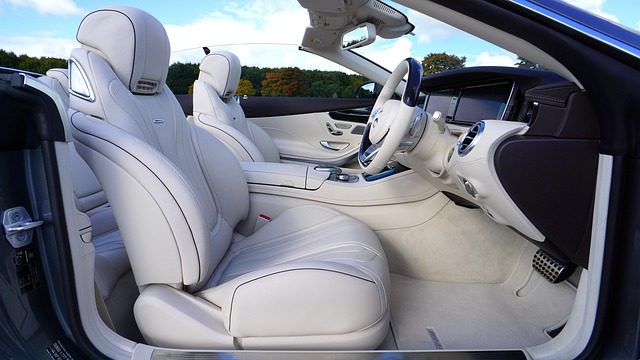

**Car-ing is sharing**, an auto dealership company for car sales and rental, is taking their services to the next level thanks to **Large Language Models (LLMs)**.

As their newly recruited AI and NLP developer, you've been asked to prototype a chatbot app with multiple functionalities that not only assist customers but also provide support to human agents in the company.

The solution should receive textual prompts and use a variety of pre-trained Hugging Face LLMs to respond to a series of tasks, e.g. classifying the sentiment in a car’s text review, answering a customer question, summarizing or translating text, etc.

## Before we start

In order to complete the project we may wish to install some Hugging Face libraries such as `transformers` and `evaluate`.

In [1]:
!pip install transformers
!pip install evaluate

from transformers import logging
logging.set_verbosity(logging.WARNING)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.3/527.3 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 18.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which i

## Import libraries

In [2]:
import pandas as pd
import torch

## Load the car reviews dataset

In [4]:
file_path = "data/car_reviews.csv"
df = pd.read_csv(file_path, delimiter=";")
df.head()

,Review,Class
0,I am very satisfied with my 2014 Nissan NV SL....,POSITIVE
1,The car is fine. It's a bit loud and not very ...,NEGATIVE
2,"My first foreign car. Love it, I would buy ano...",POSITIVE
3,I've come across numerous reviews praising the...,NEGATIVE
4,I've been dreaming of owning an SUV for quite ...,POSITIVE


## Put the car reviews and their associated sentiment labels in two lists


In [6]:
reviews = df['Review'].tolist()
real_labels = df['Class'].tolist()

In [7]:
reviews[:5]

['I am very satisfied with my 2014 Nissan NV SL. I use this van for my business deliveries and personal use. Camping, road trips, etc. We dont have any children so I store most of the seats in my warehouse. I wanted the passenger van for the rear air conditioning. We drove our van from Florida to California for a Cross Country trip in 2014. We averaged about 18 mpg. We drove thru a lot of rain and It was a very comfortable and stable vehicle. The V8 Nissan Titan engine is a 500k mile engine. It has been tested many times by delivery and trucking companies. This is why Nissan gives you a 5 year or 100k mile bumper to bumper warranty. Many people are scared about driving this van because of its size. But with front and rear sonar sensors, large mirrors and the back up camera. It is easy to drive. The front and rear sensors also monitor the front and rear sides of the bumpers making it easier to park close to objects. Our Nissan NV is a Tow Monster. It pulls our 5000 pound travel trailer 

## Instruction 1: sentiment classification

### Load a sentiment analysis LLM into a pipeline

In [8]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis', model='distilbert-base-uncased-finetuned-sst-2-english')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


### Perform inference on the car reviews and display prediction results


In [12]:
predicted_labels = classifier(reviews)
for review, prediction, label in zip(reviews, predicted_labels, real_labels):
    print(f"Review: {review}\\nActual Sentiment: {label}\\nPredicted Sentiment: {prediction['label']} (Confidence: {prediction['score']:.4f})\\n")

Review: I am very satisfied with my 2014 Nissan NV SL. I use this van for my business deliveries and personal use. Camping, road trips, etc. We dont have any children so I store most of the seats in my warehouse. I wanted the passenger van for the rear air conditioning. We drove our van from Florida to California for a Cross Country trip in 2014. We averaged about 18 mpg. We drove thru a lot of rain and It was a very comfortable and stable vehicle. The V8 Nissan Titan engine is a 500k mile engine. It has been tested many times by delivery and trucking companies. This is why Nissan gives you a 5 year or 100k mile bumper to bumper warranty. Many people are scared about driving this van because of its size. But with front and rear sonar sensors, large mirrors and the back up camera. It is easy to drive. The front and rear sensors also monitor the front and rear sides of the bumpers making it easier to park close to objects. Our Nissan NV is a Tow Monster. It pulls our 5000 pound travel tr

### Load accuracy and F1 score metrics


In [13]:

import evaluate
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")

### Map categorical sentiment labels into integer labels


In [14]:

references = [1 if label == "POSITIVE" else 0 for label in real_labels]
predictions = [1 if label['label'] == "POSITIVE" else 0 for label in predicted_labels]



### Calculate accuracy and F1 score

In [15]:
accuracy_result_dict = accuracy.compute(references=references, predictions=predictions)
accuracy_result = accuracy_result_dict['accuracy']
f1_result_dict = f1.compute(references=references, predictions=predictions)
f1_result = f1_result_dict['f1']
print(f"Accuracy: {accuracy_result}")
print(f"F1 result: {f1_result}")

Accuracy: 0.8
F1 result: 0.8571428571428571


##  Instruction 2: Translation

### Load translation LLM into a pipeline and translate car review


In [16]:
first_review = reviews[0]
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-es")
translated_review = translator(first_review, max_length=27)[0]['translation_text']
print(f"Model translation:\\n{translated_review}")

config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/312M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/44.0 [00:00<?, ?B/s]

source.spm:   0%|          | 0.00/802k [00:00<?, ?B/s]

target.spm:   0%|          | 0.00/826k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/marian/tokenization_marian.py:175: UserWarning: Recommended: pip install sacremoses.
  warnings.warn("Recommended: pip install sacremoses.")
Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.
Your input_length: 365 is bigger than 0.9 * max_length: 27. You might consider increasing your max_length manually, e.g. translator('...', max_length=400)


Model translation:\nEstoy muy satisfecho con mi 2014 Nissan NV SL. Uso esta furgoneta para mis entregas de negocios y uso personal.


### Load reference translations from file


In [17]:

with open("data/reference_translations.txt", 'r') as file:
    lines = file.readlines()
references = [line.strip() for line in lines]
print(f"Spanish translation references:\\n{references}")

Spanish translation references:\n['Estoy muy satisfecho con mi Nissan NV SL 2014. Utilizo esta camioneta para mis entregas comerciales y uso personal.', 'Estoy muy satisfecho con mi Nissan NV SL 2014. Uso esta furgoneta para mis entregas comerciales y uso personal.']


### Load and calculate BLEU score metric


In [18]:

bleu = evaluate.load("bleu")
bleu_score = bleu.compute(predictions=[translated_review], references=[references])
print(bleu_score['bleu'])


0.6022774485691839


## Instruction 3: extractive QA


###  Import auto classes

In [19]:
from transformers import AutoTokenizer
from transformers import AutoModelForQuestionAnswering

### Instantiate model and tokenizer


In [20]:

model_ckp = "deepset/minilm-uncased-squad2"
tokenizer = AutoTokenizer.from_pretrained(model_ckp)
model = AutoModelForQuestionAnswering.from_pretrained(model_ckp)

tokenizer_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/477 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/133M [00:00<?, ?B/s]

Some weights of the model checkpoint at deepset/minilm-uncased-squad2 were not used when initializing BertForQuestionAnswering: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Define context and question, and tokenize them


In [21]:

context = reviews[1]
print(f"Context:\\n{context}")
question = "What did he like about the brand?"
inputs = tokenizer(question, context, return_tensors="pt")

Context:\nThe car is fine. It's a bit loud and not very powerful. On one hand, compared to its peers, the interior is well-built. The transmission failed a few years ago, and the dealer replaced it under warranty with no issues. Now, about 60k miles later, the transmission is failing again. It sounds like a truck, and the issues are well-documented. The dealer tells me it is normal, refusing to do anything to resolve the issue. After owning the car for 4 years, there are many other vehicles I would purchase over this one. Initially, I really liked what the brand is about: ride quality, reliability, etc. But I will not purchase another one. Despite these concerns, I must say, the level of comfort in the car has always been satisfactory, but not worth the rest of issues found.


### Perform inference and extract answer from raw outputs


In [22]:

with torch.no_grad():
    outputs = model(**inputs)
    start_idx = torch.argmax(outputs.start_logits)
    end_idx = torch.argmax(outputs.end_logits) + 1
    answer_span = inputs["input_ids"][0][start_idx:end_idx]


### Decode and show answer


In [23]:

answer = tokenizer.decode(answer_span)
print("Answer: ", answer)

Answer:  ride quality, reliability


##  Instruction 4

### Get original text to summarize upon car review

In [25]:
text_to_summarize = reviews[-1]
print(f"Original text:\\n{text_to_summarize}")

Original text:\nI've been dreaming of owning an SUV for quite a while, but I've been driving cars that were already paid for during an extended period. I ultimately made the decision to transition to a brand-new car, which, of course, involved taking on new payments. However, given that I don't drive extensively, I was inclined to avoid a substantial financial commitment. The Nissan Rogue provides me with the desired SUV experience without burdening me with an exorbitant payment; the financial arrangement is quite reasonable. Handling and styling are great; I have hauled 12 bags of mulch in the back with the seats down and could have held more. I am VERY satisfied overall. I find myself needing to exercise extra caution when making lane changes, particularly owing to the blind spots resulting from the small side windows situated towards the rear of the vehicle. To address this concern, I am actively engaged in making adjustments to my mirrors and consciously reducing the frequency of l

### Load summarization pipeline and perform inference


In [26]:

model_name = "cnicu/t5-small-booksum"
summarizer = pipeline("summarization", model=model_name)
outputs = summarizer(text_to_summarize, max_length=53)
summarized_text = outputs[0]['summary_text']
print(f"Summarized text:\\n{summarized_text}")

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


Summarized text:\nthe Nissan Rogue provides me with the desired SUV experience without burdening me with an exorbitant payment; the financial arrangement is quite reasonable. I have hauled 12 bags of mulch in the back with the seats down and could have held more.
